In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1][:5]
print(case)

/home/lena/Promotion/neurolib/GUI/current/gui/data/00161_timeconst
00161


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [7]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [5., -5.]
elif case[0] == '1':
    max_I = [-5., 5.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]
elif case[3] == '6':
    cntrl_vars_init = [0]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + case[3] + '0'
    read_file = os.path.join( os.getcwd().split('data')[0], 'data_final', 'control_1.pickle')
    
if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])
print(read_file)

/home/lena/Promotion/neurolib/GUI/current/gui/data_final/control_1.pickle


In [8]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [9]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


-------  20 0.4500000000000001 0.4750000000000002


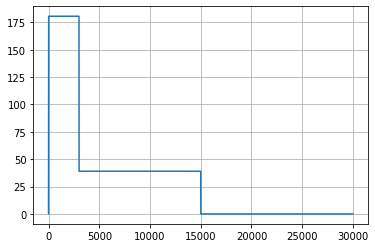

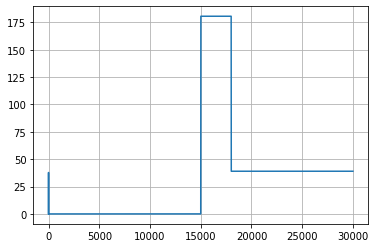

-------  50 0.47500000000000014 0.6000000000000003


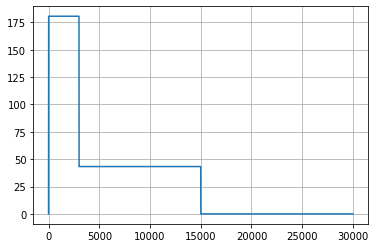

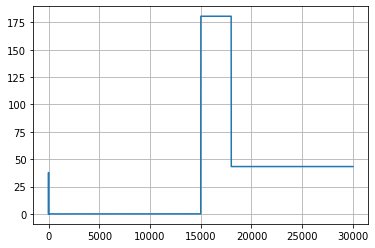

In [10]:
# get initial parameters and target states

i_range = [20, 50]
i_range_0 = [20, 50]
i_range_1 = [20, 50]

aln = ALNModel()
data.set_parameters(aln)
aln.params.tau_se = 100.
aln.params.tau_si = 50.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
            
    aln.params.duration = 30000.
    
    control0 = functions.step_control(aln, maxI_ = 5. * max_I[1])
    aln.run(control=control0)
    plt.plot(aln.t, aln.rates_exc[0,:])
    plt.show()

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    control0 = functions.step_control(aln, maxI_ = 5. * max_I[0])
    aln.run(control=control0)
    plt.plot(aln.t, aln.rates_exc[0,:])
    plt.show()
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    aln.params.duration = dur
    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]
    
    target_se = aln.state[state_vars[15]][0,-1]
    target_si = aln.state[state_vars[16]][0,-1]

In [11]:
####### default (taum = 20, tau_se = 2., tau_si = 5.)
# init =  0.00020800079839487667 22.354548572416867
# target =  [35.69070597 90.3982158 ]
# init =  2.339651407613867e-06 41.918142394968584
# target =  [ 39.92863296 107.75907077]

####### tau_se = 20.:
#init =  0.00021180204087878002 22.383255770331687
#target =  [44.69140565 98.77383452]
#init =  2.3409167776120708e-06 41.918467899776914
#target =  [ 48.06758077 114.85522069]

####### tau_se = 1.2:
#init =  0.00020792949701670254 22.35320746008562
#target =  [2.07929497e-04 2.23532075e+01]
#init =  2.3396231743335218e-06 41.91812628548801
#target =  [29.51620082 98.92173441]

####### tau_si = 50.:
#init =  init =  5.937182082638776e-12 15.498438761958193
#target =  [23.50254206 84.90163618]
#init =  2.120289475064675e-11 38.232619536365526
#target =  [ 31.59655771 104.81454101]

####### tau_si = 2.3:
#init =  0.2487947629996487 30.508167558881386
#target =  [45.15083413 93.77995084]
#init =  0.0042226752862971 45.53186755718934
#target =  [ 47.84773622 110.26148339]

for i in i_range:
    print('init = ', initVars[i][0], initVars[i][1])
    print('target rate = ', target[i][0,:,0])
    print('target mu = ', aln.state[state_vars[2]][0,-1], aln.state[state_vars[3]][0,-1])
    print('target sigma mu = ', aln.state[state_vars[15]][0,-1], aln.state[state_vars[16]][0,-1])
    print('target effective time const = ', aln.state[state_vars[18]][0,-1], aln.state[state_vars[19]][0,-1])
    print('target s = ', aln.state[state_vars[5]][0,-1], aln.state[state_vars[6]][0,-1],
          aln.state[state_vars[7]][0,-1], aln.state[state_vars[8]][0,-1])
    print('target sigma s = ', aln.state[state_vars[9]][0,-1], aln.state[state_vars[10]][0,-1],
          aln.state[state_vars[11]][0,-1], aln.state[state_vars[12]][0,-1])
    
    #print('init sigma = ', initVars[i][15], initVars[i][16])
    #print('target sigma = ', target_se, target_si)

init =  5.937182289164928e-12 15.49843876784953
target rate =  [39.00341128 98.14758252]
target mu =  1.5182581711864649 3.9581965025473633
target sigma mu =  1.5000058275922428 1.5000007961076325
target effective time const =  1.255230434322621 0.33099999999999996
target s =  0.9976658128577326 0.9942635618357054 0.9975029235800531 0.9971409138785227
target sigma s =  3.575577206670467e-07 2.6805392364420966e-06 3.807471211495538e-07 1.4652541231319621e-06
init =  2.1202897768681673e-11 38.23261955433309
target rate =  [ 43.27573472 114.39397271]
target mu =  1.5182581711864649 3.9581965025473633
target sigma mu =  1.5000058275922428 1.5000007961076325
target effective time const =  1.255230434322621 0.33099999999999996
target s =  0.9976658128577326 0.9942635618357054 0.9975029235800531 0.9971409138785227
target sigma s =  3.575577206670467e-07 2.6805392364420966e-06 3.807471211495538e-07 1.4652541231319621e-06


In [ ]:
DEFAULT

init =  0.00020800079839487667 22.354548572416867
target rate =  [35.69070597 90.3982158 ]
target mu =  1.4220238763759054 3.697864426133019
target sigma mu =  1.501171188374196 1.5008521161572805
target effective time const =  1.3912318705627278 0.36166929980545126
target s =  0.887477828043372 0.9422870441725731 0.8805462371915633 0.9704608479055169
target sigma s =  0.0007338156917096885 0.00025604742242464856 0.0007636816528595816 0.00015149491869871935


SLOW

init =  4.2149274598254106e-13 15.318759431901778
target rate =  [38.67050255 98.21070524]
target mu =  1.5103779667598598 3.960473989322073
target sigma mu =  1.5000006293719153 1.500000053784318
target effective time const =  1.2655429241150946 0.33099999999999996
target s =  0.9996077453941165 0.9980814710751048 0.9995803152307247 0.9990456282181788
target sigma s =  1.0118378494787e-08 3.0107491665371496e-07 1.0778991457841483e-08 1.6363310520954108e-07



In [150]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  302815.20560762973
Gradient descend method:  None
RUN  0 , total integrated cost =  302815.20560762973
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  372787.5448195907
Gradient descend method:  None
RUN  0 , total integrated cost =  372787.5448195907
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [169]:
factor_iteration = 1.
aln.params.duration = dur

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    ##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    with open(read_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_read = load_array[0]

    bestControl_init[i] = np.zeros(( 1, 6, n_dur + n_pre + n_post -2 ))
    bestControl_init[i][:,:,:] = bestControl_read[i][:,:,:].copy()
    weights_init = load_array[7]

    control0 = 2.4 * bestControl_init[i][:,:,n_pre-1:-n_post+1]
    control0 = 1.1 * bestControl_init[50][:,:,n_pre-1:-n_post+1]
    if i == 50:
        control0 = 1.3 * bestControl_init[i][:,:,n_pre-1:-n_post+1]   
    cost.setParams(weights_init[i][0], weights_init[i][1], weights_init[i][2])
    
    for j in range(control0.shape[2]):
        if control0[0,1,j] <= -5.:
            control0[0,1,j] = -5.

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
    control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = 0, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
    prec_variables_ = prec_vars, transition_time_ = trans_time)

with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7.15922544597912
Gradient descend method:  None
RUN  0 , total integrated cost =  7.15922544597912
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.508379657462206
Gradient descend method:  None
RUN  0 , total integrated cost =  6.508379657462206
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


--------- 20


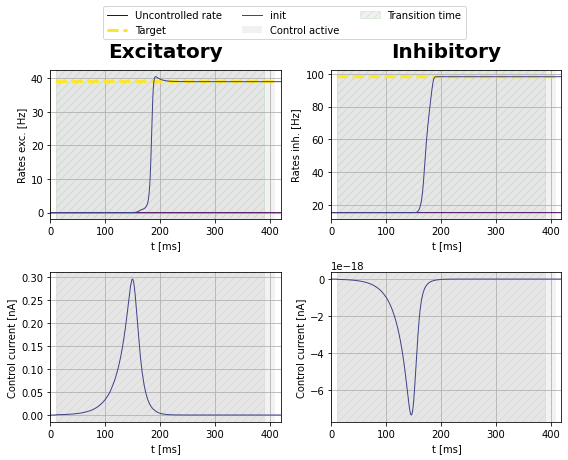

--------- 50


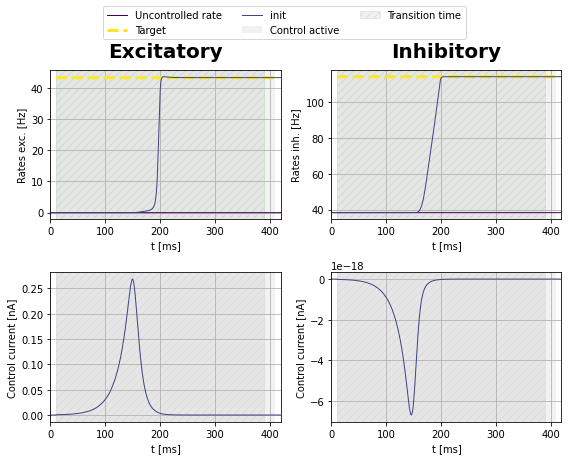

In [170]:
#plot initial guesses
for i in i_range:
    print("---------", i)
    
    setinit(initVars[i], aln)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [171]:
found_solution = []
no_solution = []
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])    
    
    if np.abs(np.mean(bestState_init[i][0,0,-100:]) - target[i][0,0,-1]) < 0.1 * np.abs(
        np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
        np.mean(bestState_init[i][0,1,-100:]) - target[i][0,1,-1]) < 0.1 * np.abs(
        np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]):
        # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
        #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
        if i not in found_solution:
            print("found solution for ", i)
            found_solution.append(i)
        if i in no_solution:
            no_solution.pop(no_solution.index(i))
        

-------  20 0.4500000000000001 0.4750000000000002
found solution for  20
-------  50 0.47500000000000014 0.6000000000000003
found solution for  50


In [172]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [173]:
factor_iteration = 6
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 6:
        break

    """  
    print(conv_0[start_index:limit:i_stepsize])
    full_converge = True
    
    for conv in conv_0[start_index:limit:i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
    """
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            print('get init control')
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
-------  20 0.4500000000000001 0.4750000000000002
get init control
weight =  42296.20210552969
set cost params:  1.0 0.0 42296.20210552969
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  302804.92588033614
Gradient descend method:  None
RUN  1 , total integrated cost =  282331.80370066944
RUN  2 , total integrated cost =  281478.75694268785
RUN  3 , total integrated cost =  281476.302580214
RUN  4 , total integrated cost =  281476.27501960244
RUN  5 , total integrated cost =  281476.274987077
RUN  6 , total integrated cost =  281476.2749870767
RUN  7 , total integrated cost =  281476.27498707664
RUN  8 , total integrated cost =  281476.27498707664
Control only changes marginally.
RUN  8 , total integrated cost =  281476.27498707664
Improved over  8  iterations in  2.5441985159995966  seconds by  7.0436935037471216  percent.
no convergence
-------  50 0.47500000000000014 0.6000000000000003
get init control
weight =  57277.088316831636
set cost p

20


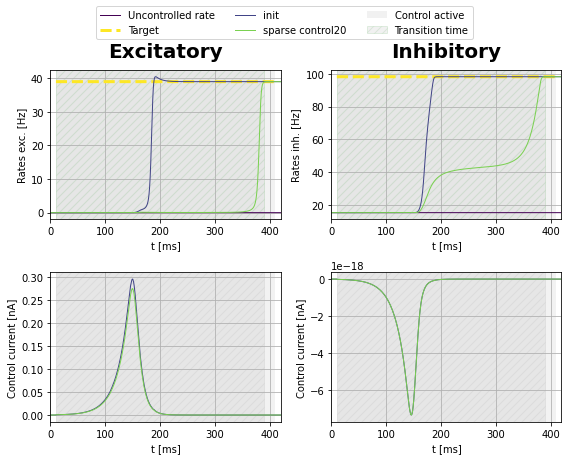

50


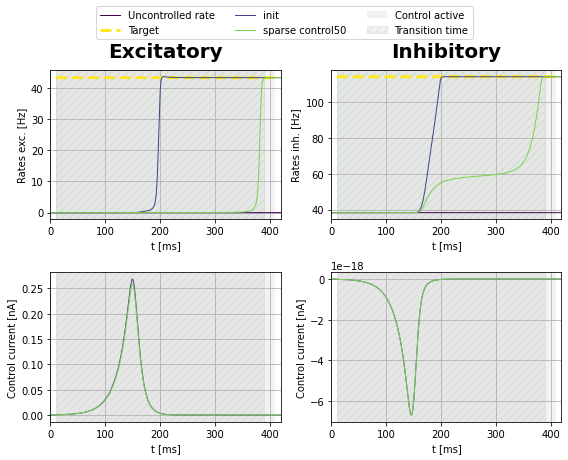

In [174]:
for i in i_range_1:
    print(i)
    
    setinit(initVars[i], aln)
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()

In [178]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [175]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

In [179]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 5:
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_init[i]

        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1
    
# 7.976298772903906

--------------- 0
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.764811744812679
Gradient descend method:  None
RUN  1 , total integrated cost =  6.654917112720295
RUN  2 , total integrated cost =  6.654917052834233
RUN  3 , total integrated cost =  6.654917052788924
RUN  4 , total integrated cost =  6.654917052788919
RUN  5 , total integrated cost =  6.654917052788918
RUN  6 , total integrated cost =  6.654917052788917
RUN  7 , total integrated cost =  6.6549170527889165
RUN  8 , total integrated cost =  6.6549170527889165
Control only changes marginally.
RUN  8 , total integrated cost =  6.6549170527889165
Improved over  8  iterations in  0.563591386002372  seconds by  1.6245048076619497  percent.
no convergence
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.39086535674055

20


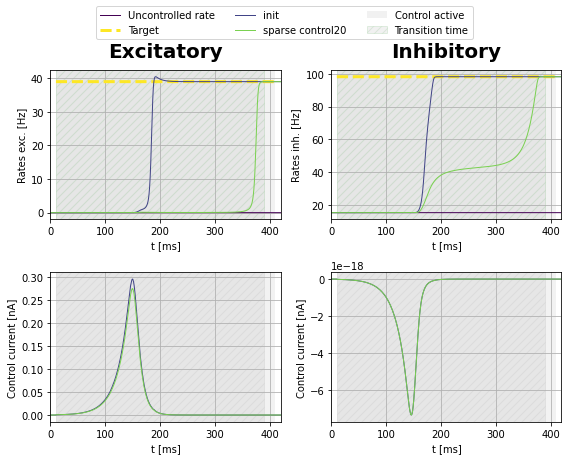

50


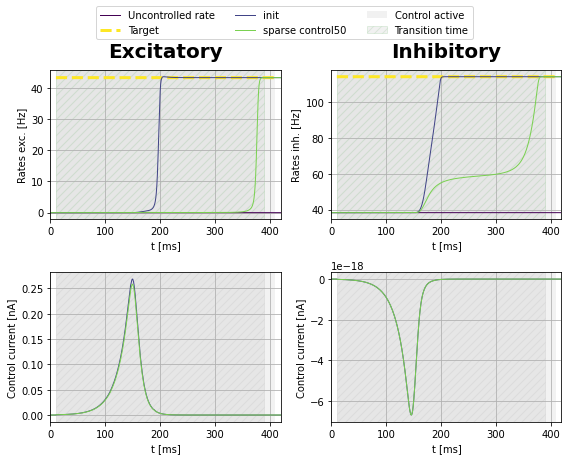

In [180]:
for i in i_range_1:
    print(i)
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_1[i]],
        [costnode_init[i], costnode_1[i]], [weights_init[i], weights_1[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()

In [32]:
print(np.amax(np.abs(bestControl_1[10][0,0,:])))

2.0577976970383847e-07
